In [2]:
import time
import numpy as np
import pandas as pd
from math import exp
import matplotlib.pyplot as plt

In [34]:
water_skull_data = pd.read_csv('/workspace/Simple_NIRs_simulation/data/super_extended_water_skull_data.csv', header=0)

water_skull_data=water_skull_data.drop(columns='Unnamed: 0')

water_skull_data

,lambda,mu_a_water,mu_a_skull
0,2.000000e+02,0.069000,6.900000
1,2.250000e+02,0.027400,2.740000
2,2.500000e+02,0.016800,1.680000
3,2.750000e+02,0.010700,1.070000
4,3.000000e+02,0.006700,0.670000
...,...,...,...
424,1.822326e+07,110.709126,33.212738
425,1.865207e+07,109.728960,32.918688
426,1.909097e+07,108.742021,32.622606
427,1.954020e+07,107.748686,32.324606


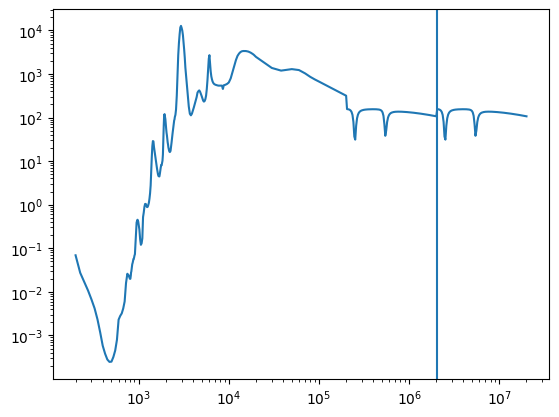

In [18]:
plt.loglog(water_skull_data['lambda'], water_skull_data['mu_a_water'])
plt.axvline(water_skull_data['lambda'][330])

In [22]:
new_data = water_skull_data

In [49]:
new_data = water_skull_data[['lambda', 'mu_a_water','mu_a_skull']].copy()

sub = 0.62
# from row 330 onwards, subtract 30
new_data.loc[330:, 'mu_a_water'] *= sub
new_data.loc[330:, 'mu_a_skull']  *= sub

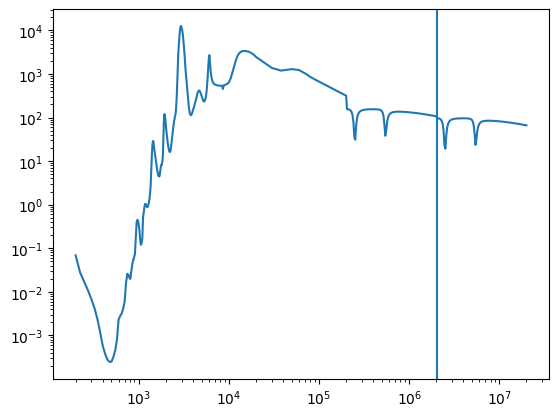

In [50]:



plt.loglog(new_data['lambda'], new_data['mu_a_water'])
plt.axvline(water_skull_data['lambda'][330])

In [53]:
new_data.to_csv('/workspace/Simple_NIRs_simulation/data/low_super_extended_water_skull_data.csv', index=False)

In [25]:
new_data['mu_a_water'] 

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
424   NaN
425   NaN
426   NaN
427   NaN
428   NaN
Name: mu_a_water, Length: 429, dtype: float64

In [1]:
import os

num_workers = os.cpu_count()
print(f"Number of available workers (CPU cores): {num_workers}")

Number of available workers (CPU cores): 192


In [112]:
import sys

def get_resolution(I0_avg, t_run, threshold_signal, pulse_snr_boost, mu_a_brain_m, mu_s_brain_p, mu_a_skull_m, mu_s_skull_p,  skull_depth_mm, depth_mm = 0.4, NEP = 1e-14):


    

    d_skull = skull_depth_mm * 1e-3
    depth   = depth_mm   * 1e-3

    # ── 1) Diffusion coefficient D = 1/[3(μₐ + μₛ′)] ───────────────────────────
    D_skull = 1.0 / (3.0 * (mu_a_skull_m   + mu_s_skull_p))
    D_brain = 1.0 / (3.0 * (mu_a_brain_m  + mu_s_brain_p))


    # ── 2) Photon time-of-flight to each layer, one‐way ──────────────────────────
    t_skull = (1.555 * d_skull) / c
    t_brain = (1.37 * depth  ) / c

    # ── 3) One-way PSF variance contributions ──────────────────────────────────
    sigma2_skull = 2.0 * D_skull * t_skull
    sigma2_brain = 2.0 * D_brain * t_brain

    # combined one-way RMS width (m)
    sigma_oneway = np.sqrt(sigma2_skull + sigma2_brain)

    # two-way adds another pass through both layers
    sigma_total = np.sqrt(2.0) * sigma_oneway

    # infinite-SNR resolution (FWHM in m)
    FWHM_inf = 2.35 * sigma_total

    # ── 4) Center-spot signal and total SNR ─────────────────────────────────────
    # Total energy delivered per area
    E_incident = I0_avg * t_run


    # Convert skull μₐ to per-m if it isn’t already:
    mu_a_skull_m   = mu_a_skull_m        # cm⁻¹ → m⁻¹
 

    # two-way transmission through skull:
    F_skull = np.exp(-2.0 * mu_a_skull_m * d_skull)

    # Energy returning at zero lateral offset
    E_center = E_incident * F_skull * np.exp(-2.0 * mu_a_brain_m * depth)

    # Total SNR including pulse averaging
    # (E_center/threshold_sig) is SNR for a single detection window
    SNR_total = (E_center / threshold_signal) * pulse_snr_boost

    #print('SNR total: ', SNR_total)

    # ── 5) Noise-limited resolution ─────────────────────────────────────────────
    # Solve exp(-r²/(2σ²)) = 1/SNR  ⇒  r_lim = σ √[2 ln(SNR)]
    if SNR_total <= 1.0:
        # no detectable spot — resolution is infinite
        FWHM_noise = np.inf
    else:
        # compute the true noise-limited radius
        r_lim      = sigma_total * np.sqrt(2.0 * np.log(SNR_total))
        FWHM_noise = 2.0 * r_lim



    return [1/(FWHM_noise*1e3), 1/(FWHM_inf*1e3)]


In [113]:
def get_thermal_coefficient(
    mu_a: float,
    rho: float = 1040,
    c_p: float = 3650
) -> float:
    """
    Compute thermal coefficient for brain tissue that converts irradiance to
    heating rate (dT/dt) per unit irradiance [K per (W/m²·s)].

    Parameters
    ----------
    mu_a : float
        Absorption coefficient at the wavelength of interest [m⁻¹].
    rho : float
        Tissue density [kg/m³]. Default ~1040 for brain.
    c_p : float
        Specific heat capacity [J/(kg·K)]. Default ~3650 for brain.

    Returns
    -------
    thermal_coeff : float
        Heating rate per irradiance [K/(W/m²·s)].
    """
    # dT/dt = mu_a * I / (rho * c_p)  => thermal_coeff = mu_a/(rho*c_p)
    return mu_a / (rho * c_p)



def max_detectable_depth(
    I0: float,
    exposure_time: float,
    mu_a_brain: float,
    mu_s_prime_brain: float,
    skull: bool = False,
    mu_a_skull: float = None,
    mu_s_prime_skull: float = None,
    skull_thickness_mm: float = 6,
    NEP: float = 1e-14,
    threshold_signal: float = None
) -> dict:
    """
    Estimate the maximum one-way brain depth at which a returned optical signal
    remains above the detection threshold of a modern photodetector.

    Parameters
    ----------
    I0 : float
        Incident irradiance (power per area) on tissue [W/m²].
    exposure_time : float
        Total exposure/integration time [s].
    mu_a_brain : float
        Brain absorption coefficient at the wavelength of interest [m⁻¹].
    skull : bool, optional
        Whether to include skull attenuation (default: False).
    mu_a_skull : float, optional
        Skull absorption coefficient [m⁻¹] (required if skull=True).
    skull_thickness_mm : float, optional
        Skull thickness [mm] (required if skull=True).
    NEP : float, optional
        Noise Equivalent Power of detector [W/√Hz] (default 1e-12 W/√Hz citeturn0search4).
    threshold_signal : float, optional
        Absolute minimum detectable signal energy per unit area [J/m²].
        If None, computed from NEP and exposure_time:
            noise_bandwidth ≈ 1 / exposure_time  [Hz]
            threshold_power = NEP * √noise_bandwidth  [W/m²]
            threshold_signal = threshold_power * exposure_time  [J/m²]

    Returns
    -------
    dict
        - max_depth_mm: maximum detectable one-way depth [mm]
        - threshold_signal_J_m2: signal-energy threshold used [J/m²]
        - F_skull: round-trip skull transmission factor (if skull=True)
        - status: "OK" or reason why no detection possible
    """

    # Compute round-trip skull factor
    F_skull = 1.0
    if skull:
        if mu_a_skull is None or skull_thickness_mm is None:
            raise ValueError("mu_a_skull and skull_thickness_mm must be set if skull=True.")
        skull_thickness_m = skull_thickness_mm * 1e-3
        # Round-trip through skull
        F_skull = np.exp(-2 * mu_a_skull * skull_thickness_m)

    # Compute total incident energy per area
    E_incident = I0 * exposure_time  # [J/m²]

    # Check if any detection is possible
    if E_incident * F_skull <= threshold_signal:
        return {
            "max_depth_mm": 0.0,
            "threshold_signal_J_m2": threshold_signal,
            "F_skull": F_skull,
            "status": "No depth: incident×skull < threshold"
        }

    # Solve for depth: E_signal(depth) = E_incident * F_skull * exp(-2 μ_a_brain d) ≥ threshold_signal
    # ⇒ exp(-2 μ_a_brain d) ≥ threshold_signal / (E_incident * F_skull)
    frac_required = threshold_signal / (E_incident * F_skull)
    max_depth_m = -np.log(frac_required) / (2 * mu_a_brain)
    max_depth_mm = max_depth_m * 1e3

    return {
        "max_depth_mm": max_depth_mm,
        "threshold_signal_J_m2": threshold_signal,
        "F_skull": F_skull,
        "status": "OK"
    }


def optimize_pulse_schedule(
    wavelength: float,
    amplitude_grid: np.ndarray,
    mu_a_brain: float,
    mu_s_brain_p: float,
    pulse_freq_grid = np.logspace(3, 9, 50),
    pulse_duration_grid= np.logspace(-14, -9, 50),
    skull: bool = False,
    mu_a_skull: float = None,
    mu_s_skull_p: float = None,
    skull_thickness_mm: float = None,
    NEP: float = 1e-14,
    arrhenius_threshold: float = 0.00321,
    arrhenius_threshold_pulse: float = None,
    max_stimulation_per_trial: float = 8.,
    tau_brain: float = 2.,
    verbose: bool = False,
    num_loops: int = None
) -> dict:
    """
    Optimize pulse amplitude & repetition rate for maximum penetration depth
    under an Arrhenius damage limit, accounting for wavelength-specific
    absorption in thermal modeling.

    Parameters
    ----------
    wavelength : float
        Laser wavelength (m).
    amplitude_grid : array-like
        Photon flux values to test [photons/m²/s].
    pulse_freq_grid : array-like
        Laser repetition rates to test (Hz).
    duty : float
        Fraction of each cycle the laser is ON (0 < duty ≤ 1).
    mu_a_brain : float
        Brain absorption coefficient at this wavelength [m⁻¹].
    skull, mu_a_skull, skull_thickness_mm, NEP : see depth function.
    arrhenius_threshold : float
        Maximum allowed Arrhenius damage integral Ω.
    max_time : float
        Upper cap on exposure time (s).

    Returns
    -------
    dict
        {
          'optimal_amplitude': float,  # photon flux
          'optimal_freq': float,       # Hz
          'optimal_duty': float,
          'max_exposure_time': float,
          'max_depth_mm': float,
          'omega': float
        }
    """
    if arrhenius_threshold_pulse is None:
        arrhenius_threshold_pulse = arrhenius_threshold



    best = {
        'optimal_amplitude': None,
        'optimal_freq':      None,
        'max_exposure_time': 0.0,
        'max_depth_mm':      0.0,
        'omega':             None,
        'max_trials':          0,
        'max_time':            0,
        'res_0_depth':         [0,0],
        'res_04_depth':         [0,0],
        'res_max_depth':         [0,0]
    }

    Ω_threshold = arrhenius_threshold
    Ω_threshold_pulse = arrhenius_threshold_pulse

    # Photon energy (J per photon)
    E_photon      = h * c / wavelength
    thermal_coeff = get_thermal_coefficient(mu_a_brain)

    idx_max = len(amplitude_grid) * len(pulse_freq_grid) * len(pulse_duration_grid)
    # Sweep amplitude and repetition rate
    for amplitude in amplitude_grid:

        I0_peak = amplitude * E_photon  # surface irradiance [W/m²]

        for freq in pulse_freq_grid:

            for idx, pulse_dt in enumerate(pulse_duration_grid):

                if idx == 0 and verbose:
                    before = time.time()

                # Compute pulse on-time
                if pulse_dt * freq > 1:
                    print('A pulse duration is too long to fit a second a the given freq')
                    continue

                average_time_on   = pulse_dt * freq         # s

                # Average Irradiance at brain surface
                I0_avg = I0_peak * average_time_on  

                dT_peak = I0_peak * thermal_coeff

                T_pulse_increase = dT_peak * pulse_dt

              

                T0 = 309.85

                T = T0

                # dt_off = (freq * pulse_dt) / (freq-1)

                period = 1.0/freq
                dt_off = period - pulse_dt


                N_max = max_stimulation_per_trial * freq

                t_max = 0

                Ω_pulse = 0

                #for cycle in range(int(N_max)):
                N_cycles_used = 0
                for cycle in range(int(min(N_max, 5000) )):
                    
                    N_cycles_used += 1


                    # 1) Heat: assume nearly constant T during the short on‐pulse
                   
                    T += T_pulse_increase

                    t_max += pulse_dt
                    
                    # Integrate Arrhenius over the on‐time
                    k_on = A_arr * exp(-Ea_arr/(R_gas * T))  #TODO check R gas
                    Ω_pulse += k_on * pulse_dt
                    
                    # Break if damage limit reached
                    if Ω_pulse >= Ω_threshold_pulse:
                        break
                    
                    # 2) Cool during the off‐time (exponential decay toward baseline)
                    T = T0 + (T - T0) * exp(-dt_off / tau_brain)
                
                max_trials = Ω_threshold / Ω_pulse

                snr_boost   = np.sqrt(N_cycles_used)

                # Compute penetration depth

                noise_bandwidth = 1.0 / t_max
                threshold_power = NEP * np.sqrt(noise_bandwidth)
                threshold_signal = threshold_power * t_max
               

             
                    
       
                res   = max_detectable_depth(I0 = I0_avg, exposure_time=t_max, mu_a_brain=mu_a_brain, mu_s_prime_brain=mu_s_brain_p,
                                             skull=skull, mu_a_skull=mu_a_skull, mu_s_prime_skull=mu_s_skull_p, skull_thickness_mm=skull_thickness_mm,
                                             NEP=NEP, threshold_signal=threshold_signal)
                depth = res['max_depth_mm']

                res_0_depth = get_resolution(I0_avg, t_max, threshold_signal, snr_boost,
                                mu_a_brain, mu_s_brain_p, mu_a_skull, mu_s_skull_p,
                                   skull_thickness_mm,
                                    depth_mm = 0.0, NEP = NEP)
                
                if depth>=0.4:

                    res_04_depth = get_resolution(I0_avg, t_max, threshold_signal, snr_boost,
                                mu_a_brain, mu_s_brain_p, mu_a_skull, mu_s_skull_p,
                                   skull_thickness_mm,
                                    depth_mm = 0.4, NEP = NEP)
                else:
                    res_04_depth = [0,0]

                res_max_depth = get_resolution(I0_avg, t_max, threshold_signal, snr_boost,
                                mu_a_brain, mu_s_brain_p, mu_a_skull, mu_s_skull_p,
                                   skull_thickness_mm,
                                    depth_mm = depth, NEP = NEP)
         

                # Update if improved
                if depth > best['max_depth_mm']:
                    best.update({
                        'optimal_amplitude': amplitude,
                        'optimal_freq':      freq,
                        'max_exposure_time': t_max,
                        'max_depth_mm':      depth,
                        'omega':             Ω_pulse,
                        'max_trials':       max_trials,
                        'max_time':         max_trials * max_stimulation_per_trial,
                        'res_0_depth':         res_0_depth,
                        'res_04_depth':         res_04_depth,
                        'res_max_depth':         res_max_depth
                    })

                if idx == 0 and verbose:
                    comp_duration = time.time() - before
                    print(f"Cycle duration is {comp_duration} seconds")

                    print(f"Expected total compute duration is {idx_max * comp_duration * num_loops // 60 / 60} hours, or {idx_max * comp_duration * num_loops // 60 } minutes")
                    verbose = False

    return best

In [ ]:
import os
from concurrent.futures import ProcessPoolExecutor, as_completed
# Physical constants
h = 6.62607015e-34  # Planck constant, J·s
c = 2.99792458e8    # Speed of light, m/s

# Tissue baseline temperature
T0 = 310.15         # K (37 °C)

# Arrhenius parameters (example values)
A_arr = 3.1e98      # s⁻¹ (frequency factor)
Ea_arr = 6.28e5     # J/mol (activation energy)
R_gas = 8.314       # J/(mol·K)


arrhenius_threshold = 0.00321 # Equivalent to CEM 43 degrees Celsius for 10 minutes

arrhenius_threshold_pulse = arrhenius_threshold / 100

max_stimulation_per_trial = 16

tau_brain = 2

#           1. Figure out how many logical CPUs (hardware threads) you have:
max_workers = os.cpu_count()   # e.g. 16 on a 8‑core/16‑thread machine
print(f"Detected {max_workers} logical CPUs")
amplitude_grid = np.logspace(18, 25, 3)
pulse_freq_grid = np.logspace(3, 9, 3)
pulse_duration_grid= np.logspace(-14, -9, 3)
# 2. Build the list of argument‑dicts you want to map:
tasks = []
for wavelength, mu_water, mu_skull in water_skull_data.values:
    tasks.append({
        'wavelength': wavelength,
        'amplitude_grid': amplitude_grid,
        'mu_a_brain': mu_water * 100,
        'mu_s_brain_p': 7 * 100,
        'pulse_freq_grid': pulse_freq_grid,
        'pulse_duration_grid': pulse_duration_grid,
        'skull': True,
        'mu_a_skull': mu_skull * 100,
        'mu_s_skull_p': 7 * 100,
        'skull_thickness_mm': 5.5,
        'NEP': 1e-13,
        'arrhenius_threshold': arrhenius_threshold,
        'arrhenius_threshold_pulse': arrhenius_threshold_pulse,
        'max_stimulation_per_trial': max_stimulation_per_trial,
        'tau_brain': tau_brain,
        'verbose': False,
        'num_loops': len(water_skull_data['lambda'])
    })



# 3. Spawn a pool of worker processes:
with ProcessPoolExecutor(max_workers=14) as executor:
    futures = [executor.submit(optimize_pulse_schedule, **kw) for kw in tasks]

    results = []
    for future in as_completed(futures):
        try:
            results.append(future.result())
        except Exception as e:
            print("Worker raised:", e)


depths = [result['max_depth_mm'] for result in results]

res_0 = [result['res_0_depth'][0] for result in results]
res_04 = [result['res_04_depth'][0] for result in results]
res_max = [result['res_max_depth'][0] for result in results]

res_0_inf = [result['res_0_depth'][1] for result in results]
res_04_inf = [result['res_04_depth'][1] for result in results]
res_max_inf = [result['res_max_depth'][1] for result in results]

exposures = [result['max_exposure_time'] for result in results]

times = [result['max_time'] for result in results]


rr = [['depths',depths], ['res_0',res_0], ['res_0_inf',res_0_inf], ['res_04',res_04],['res_04_inf',res_04_inf],
       ['res_max',res_max],['res_max_inf',res_max_inf],   ['exposures',exposures], ['times',times]]

Detected 16 logical CPUs


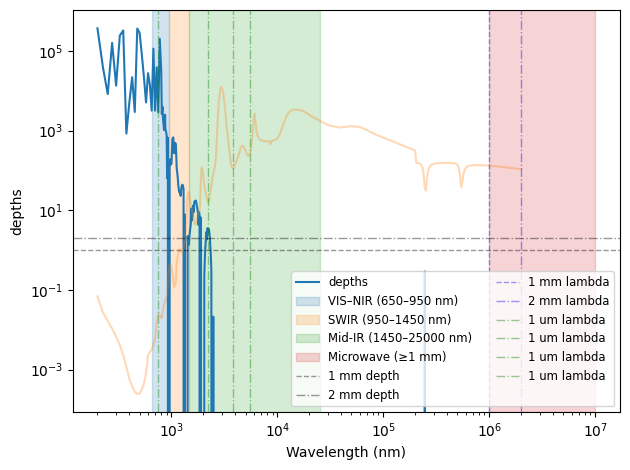

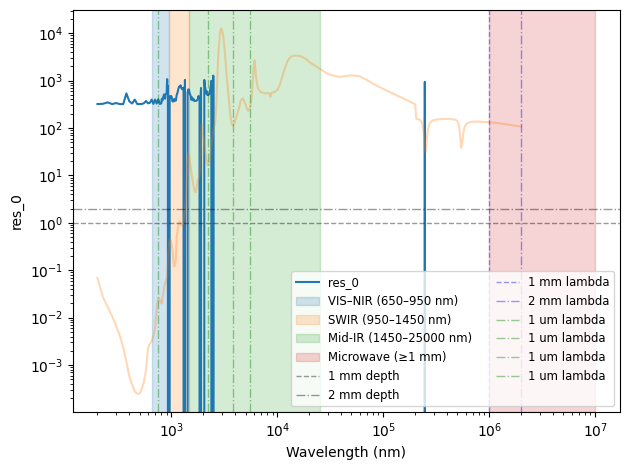

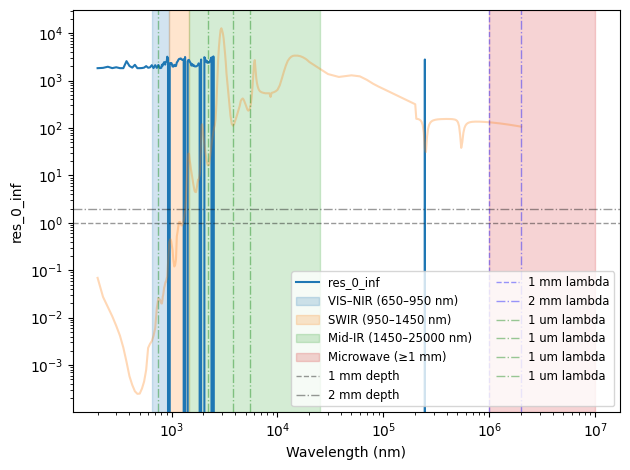

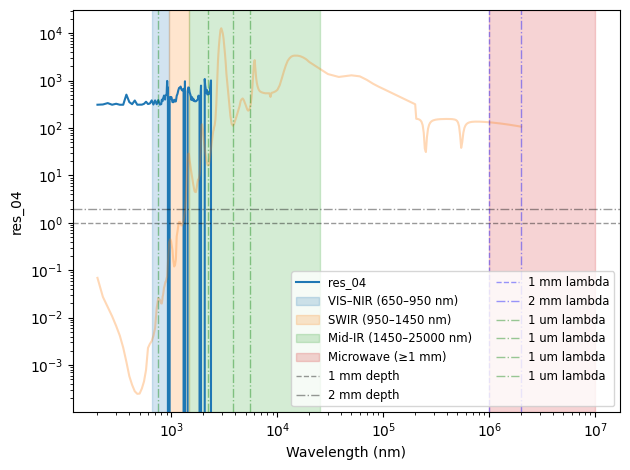

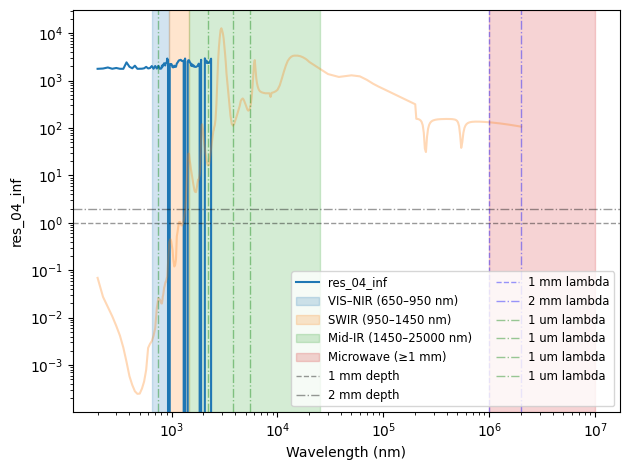

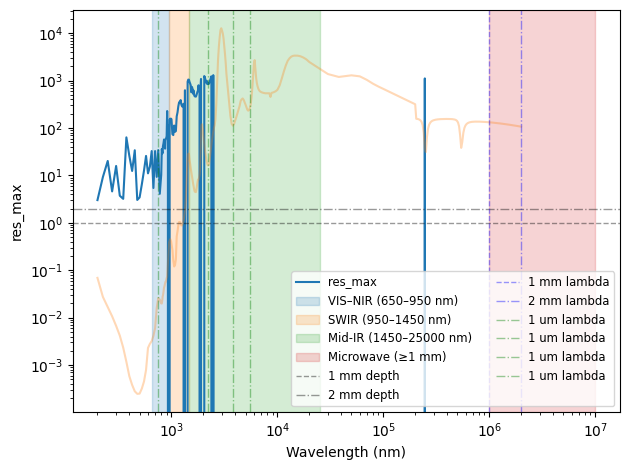

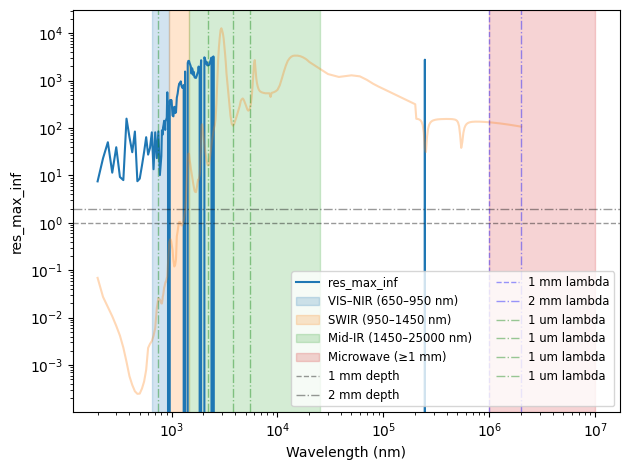

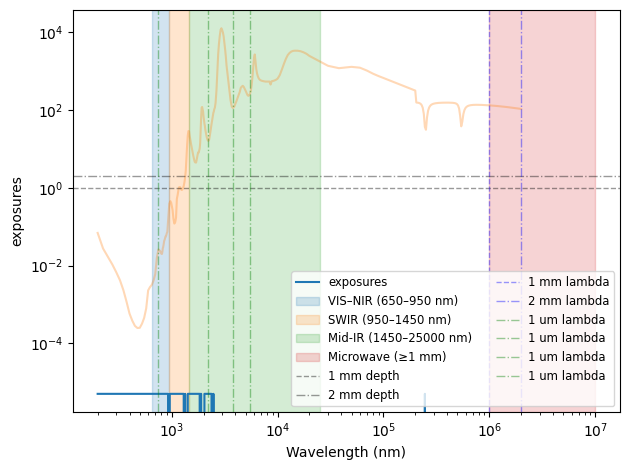

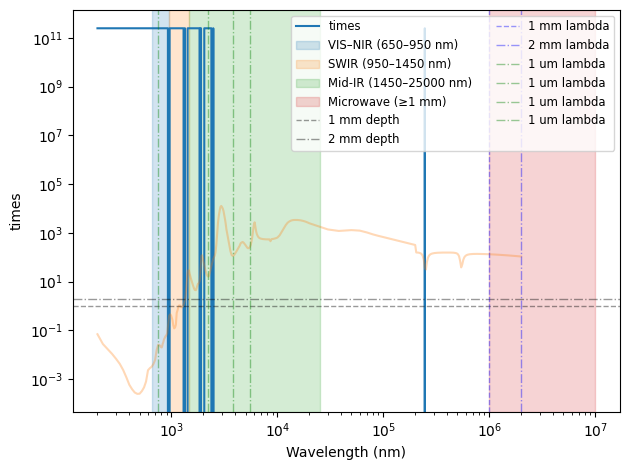

In [125]:
for r in rr:
    plot_spectrum(r[1], label=r[0])
